In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### Accent Region Comparisons

In [19]:
import pandas as pd

# === Load the final results CSV for all models ===
df_aasist = pd.read_csv("aasist_env/final_results5.csv")
df_aasist_l = pd.read_csv("aasist_env/final_results6.csv")  # AASIST-L model
# df_rawnet2 = pd.read_csv("rawnet2/rawnet_env/final_results_rawnet2.csv") # RawNet2 model
# df_tssd = pd.read_csv("tssdnet/tssd_env/final_results_tssd.csv")  # TSSD model

# === Define the classification threshold ===
THRESHOLD = 0.5

# Function to clean accent names (remove parentheses and anything after)
def clean_accent_name(accent):
    return accent.split("(")[0].strip()

# Apply cleaning function to all datasets
# for df in [df_aasist, df_aasist_l, df_rawnet2, df_tssd]:
for df in [df_aasist, df_aasist_l]:
    df["region"] = df["region"].apply(clean_accent_name)

# === Standardize Predictions: 1 = Spoof, 0 = Bonafide ===
df_aasist["predicted_spoof"] = (df_aasist["prediction_score"] < THRESHOLD).astype(int)
df_aasist_l["predicted_spoof"] = (df_aasist_l["prediction_score"] < THRESHOLD).astype(int)
# df_rawnet2["predicted_spoof"] = (df_rawnet2["prediction_score"] < THRESHOLD).astype(int)
# df_tssd["predicted_spoof"] = (df_tssd["prediction_score"] < THRESHOLD).astype(int) # **Fixed for TSSD: It predicts the opposite, but fixed in code (bonafide = 0, spoof = 1)**

# **Fix: Assume ground truth is all real (1) since FPR assumes no spoofed examples**
# for df in [df_aasist, df_aasist_l, df_rawnet2, df_tssd]:
for df in [df_aasist, df_aasist_l]:
    df["actual_label"] = 1  # All samples assumed to be bonafide

# === Compute FP (False Positives) and TN (True Negatives) ===
# for df in [df_aasist, df_aasist_l, df_rawnet2, df_tssd]:
for df in [df_aasist, df_aasist_l]:
    df["FP"] = (df["predicted_spoof"] == 1) & (df["actual_label"] == 1)  # False spoof detection
    df["TN"] = (df["predicted_spoof"] == 0) & (df["actual_label"] == 1)  # Correctly identified bonafide

# === Function to Compute Region-wise Metrics ===
def compute_region_metrics(df, model_name):
    region_metrics = df.groupby("region").agg(
        total_samples=("actual_label", "count"),
        false_positives=("FP", "sum"),
        true_negatives=("TN", "sum")
    )
    region_metrics["FPR"] = region_metrics["false_positives"] / region_metrics["total_samples"]
    region_metrics["TNR"] = region_metrics["true_negatives"] / region_metrics["total_samples"]
    region_metrics = region_metrics.reset_index()
    region_metrics["Model"] = model_name
    return region_metrics

# === Compute region-wise metrics for all models ===
region_metrics_aasist = compute_region_metrics(df_aasist, "AASIST")
region_metrics_aasist_l = compute_region_metrics(df_aasist_l, "AASIST-L")
# region_metrics_rawnet2 = compute_region_metrics(df_rawnet2, "RawNet2")
# region_metrics_tssd = compute_region_metrics(df_tssd, "TSSD")  # New TSSD model

# === Combine results into a single DataFrame for comparison ===
region_metrics_combined = pd.concat(
    # [region_metrics_aasist, region_metrics_aasist_l, region_metrics_rawnet2, region_metrics_tssd],
    [region_metrics_aasist, region_metrics_aasist_l],
    ignore_index=True
)

# === Print confirmation ===
print("All models' region-wise metrics successfully computed and combined!")

All models' region-wise metrics successfully computed and combined!


In [20]:
region_metrics_combined

,region,total_samples,false_positives,true_negatives,FPR,TNR,Model
0,british isles,100,54,46,0.540000,0.460000,AASIST
1,caribbean,100,56,44,0.560000,0.440000,AASIST
2,east asia,100,46,54,0.460000,0.540000,AASIST
3,middle east & central asia,92,61,31,0.663043,0.336957,AASIST
4,north america,100,45,55,0.450000,0.550000,AASIST
5,south asia,100,61,39,0.610000,0.390000,AASIST
6,southeast asia,100,27,73,0.270000,0.730000,AASIST
7,sub-saharan africa,100,35,65,0.350000,0.650000,AASIST
8,western europe,100,60,40,0.600000,0.400000,AASIST
9,british isles,100,70,30,0.700000,0.300000,AASIST-L


In [22]:
# === Function to calculate confidence intervals for proportions using Wilson Score Interval ===
def compute_confidence_interval(proportion, total, confidence=0.95):
    """Compute the confidence interval for a proportion using the Wilson Score Interval."""
    if total == 0:
        return (0, 0)
    z = stats.norm.ppf((1 + confidence) / 2)  # Z-score for confidence level
    p = proportion
    n = total
    center = (p + (z**2) / (2 * n)) / (1 + (z**2) / n)
    margin = (z * np.sqrt((p * (1 - p) / n) + (z**2) / (4 * n**2))) / (1 + (z**2) / n)
    return center - margin, center + margin

# === Function to apply CI computation for both FPR & TNR ===
def apply_confidence_intervals(df):
    df["FPR_CI_Lower"], df["FPR_CI_Upper"] = zip(*df.apply(
        lambda row: compute_confidence_interval(row["FPR"], row["total_samples"]),
        axis=1
    ))
    df["TNR_CI_Lower"], df["TNR_CI_Upper"] = zip(*df.apply(
        lambda row: compute_confidence_interval(row["TNR"], row["total_samples"]),
        axis=1
    ))
    return df

# === Apply confidence interval calculation to all models ===
# all_region_metrics = [region_metrics_aasist, region_metrics_aasist_l, region_metrics_rawnet2, region_metrics_tssd]
all_region_metrics = [region_metrics_aasist, region_metrics_aasist_l]

for i, df in enumerate(all_region_metrics):
    all_region_metrics[i] = apply_confidence_intervals(df)

# apply_confidence_intervals(all_region_metrics)
# region_metrics_aasist, region_metrics_aasist_l, region_metrics_rawnet2, region_metrics_tssd = all_region_metrics
region_metrics_aasist, region_metrics_aasist_l = all_region_metrics
# region_metrics_aasist = pd.DataFrame(all_region_metrics)

# === Combine all models into a single DataFrame ===
combined_fpr = pd.concat([
    region_metrics_aasist[["region", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]],
    region_metrics_aasist_l[["region", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]]# ,
#     region_metrics_rawnet2[["region", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]],
#     region_metrics_tssd[["region", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]]
], ignore_index=True)

# combined_fpr = region_metrics_aasist[["region", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]]

combined_tnr = pd.concat([
    region_metrics_aasist[["region", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]],
    region_metrics_aasist_l[["region", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]]# ,
    # region_metrics_rawnet2[["region", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]],
    # region_metrics_tssd[["region", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]]
], ignore_index=True)

# combined_tnr = region_metrics_aasist[["region", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]]

# === Print confirmation ===
print("Confidence intervals applied and all models successfully combined!")

Confidence intervals applied and all models successfully combined!


In [24]:
combined_tnr

,region,TNR,TNR_CI_Lower,TNR_CI_Upper,Model
0,british isles,0.460000,0.365608,0.557351,AASIST
1,caribbean,0.440000,0.346720,0.537719,AASIST
2,east asia,0.540000,0.442649,0.634392,AASIST
3,middle east & central asia,0.336957,0.248636,0.438347,AASIST
4,north america,0.550000,0.452446,0.643855,AASIST
5,south asia,0.390000,0.300169,0.487970,AASIST
6,southeast asia,0.730000,0.635679,0.807304,AASIST
7,sub-saharan africa,0.650000,0.552544,0.736358,AASIST
8,western europe,0.400000,0.309401,0.497997,AASIST
9,british isles,0.300000,0.218949,0.395849,AASIST-L


In [25]:
combined_fpr

,region,FPR,FPR_CI_Lower,FPR_CI_Upper,Model
0,british isles,0.540000,0.442649,0.634392,AASIST
1,caribbean,0.560000,0.462281,0.653280,AASIST
2,east asia,0.460000,0.365608,0.557351,AASIST
3,middle east & central asia,0.663043,0.561653,0.751364,AASIST
4,north america,0.450000,0.356145,0.547554,AASIST
5,south asia,0.610000,0.512030,0.699831,AASIST
6,southeast asia,0.270000,0.192696,0.364321,AASIST
7,sub-saharan africa,0.350000,0.263642,0.447456,AASIST
8,western europe,0.600000,0.502003,0.690599,AASIST
9,british isles,0.700000,0.604151,0.781051,AASIST-L


In [25]:
combined_fpr

,region,FPR,FPR_CI_Lower,FPR_CI_Upper,Model
0,british isles,0.41,0.318673,0.507986,AASIST
1,multiple accents,0.52,0.423166,0.615354,AASIST
2,north america,0.31,0.227797,0.406261,AASIST
3,other,0.53,0.432889,0.624892,AASIST
4,south asia,0.53,0.432889,0.624892,AASIST
5,southeast asia,0.17,0.108936,0.255480,AASIST
6,sub-saharan africa,0.26,0.184047,0.353710,AASIST
0,british isles,0.42,0.327984,0.517935,AASIST-L
1,multiple accents,0.57,0.472154,0.662667,AASIST-L
2,north america,0.37,0.281824,0.467795,AASIST-L


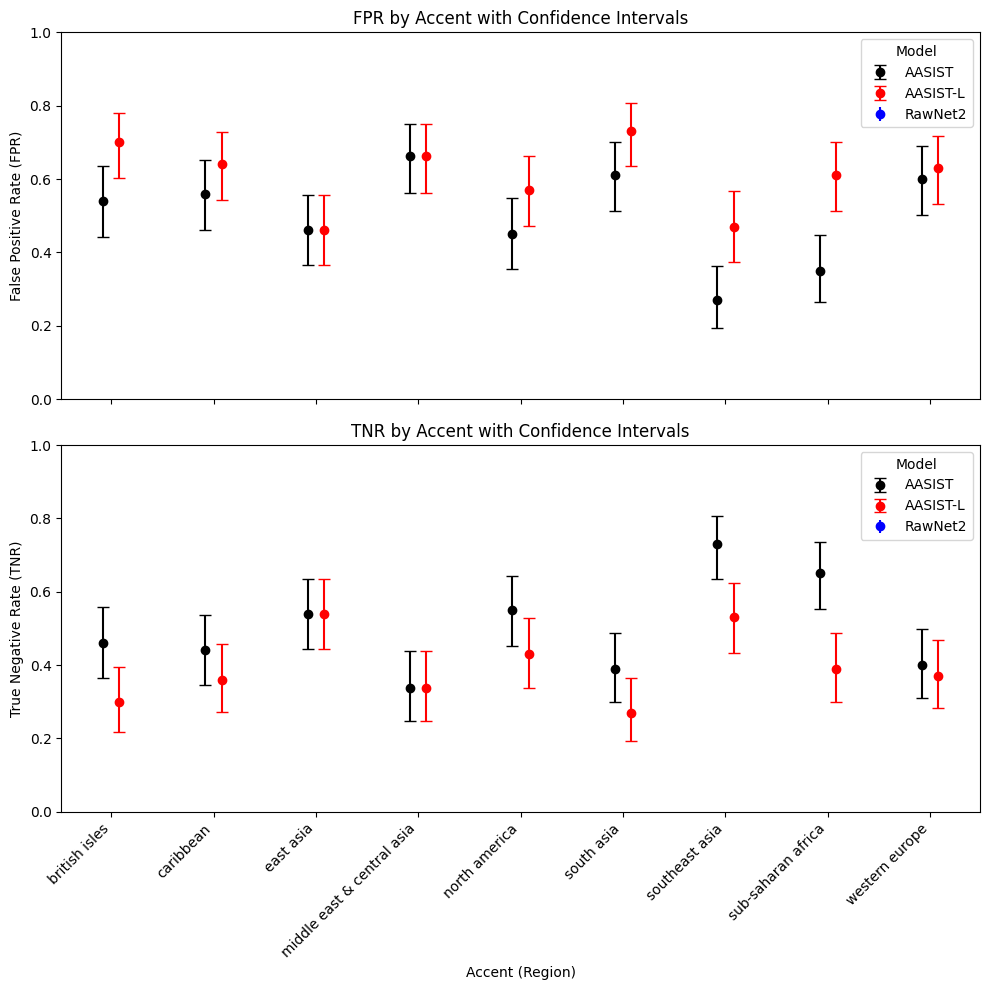

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Create a vertically stacked plot for FPR and TNR
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

offset = 0.08  # Offset to shift models slightly apart for clarity

# Define model colors and offsets
model_colors = {"AASIST": "black", "AASIST-L": "red", "RawNet2": "blue"}
model_offsets = {"AASIST": -offset, "AASIST-L": offset, "RawNet2": -offset*3}

# Plot FPR with confidence intervals on the first subplot
for model in model_colors.keys():
    subset = combined_fpr[combined_fpr["Model"] == model]
    x_positions = np.arange(len(subset["region"])) + model_offsets[model]  # Apply offset
    axes[0].errorbar(x_positions, subset["FPR"], 
                      yerr=[subset["FPR"] - subset["FPR_CI_Lower"], subset["FPR_CI_Upper"] - subset["FPR"]], 
                      fmt="o", color=model_colors[model], capsize=4, label=model)

axes[0].set_ylabel("False Positive Rate (FPR)")
axes[0].set_title("FPR by Accent with Confidence Intervals")
axes[0].legend(title="Model")
axes[0].set_ylim(0, 1)  # Ensure values are between 0 and 1

# Plot TNR with confidence intervals on the second subplot
for model in model_colors.keys():
    subset = combined_tnr[combined_tnr["Model"] == model]
    x_positions = np.arange(len(subset["region"])) + model_offsets[model]  # Apply offset
    axes[1].errorbar(x_positions, subset["TNR"], 
                      yerr=[subset["TNR"] - subset["TNR_CI_Lower"], subset["TNR_CI_Upper"] - subset["TNR"]], 
                      fmt="o", color=model_colors[model], capsize=4, label=model)

axes[1].set_ylabel("True Negative Rate (TNR)")
axes[1].set_title("TNR by Accent with Confidence Intervals")
axes[1].legend(title="Model")
axes[1].set_ylim(0, 1)  # Ensure values are between 0 and 1

# Set x-axis labels and ticks
plt.xticks(ticks=np.arange(len(combined_fpr["region"].unique())), 
           labels=combined_fpr["region"].unique(), rotation=45, ha="right")
plt.xlabel("Accent (Region)")

plt.tight_layout()
plt.show()

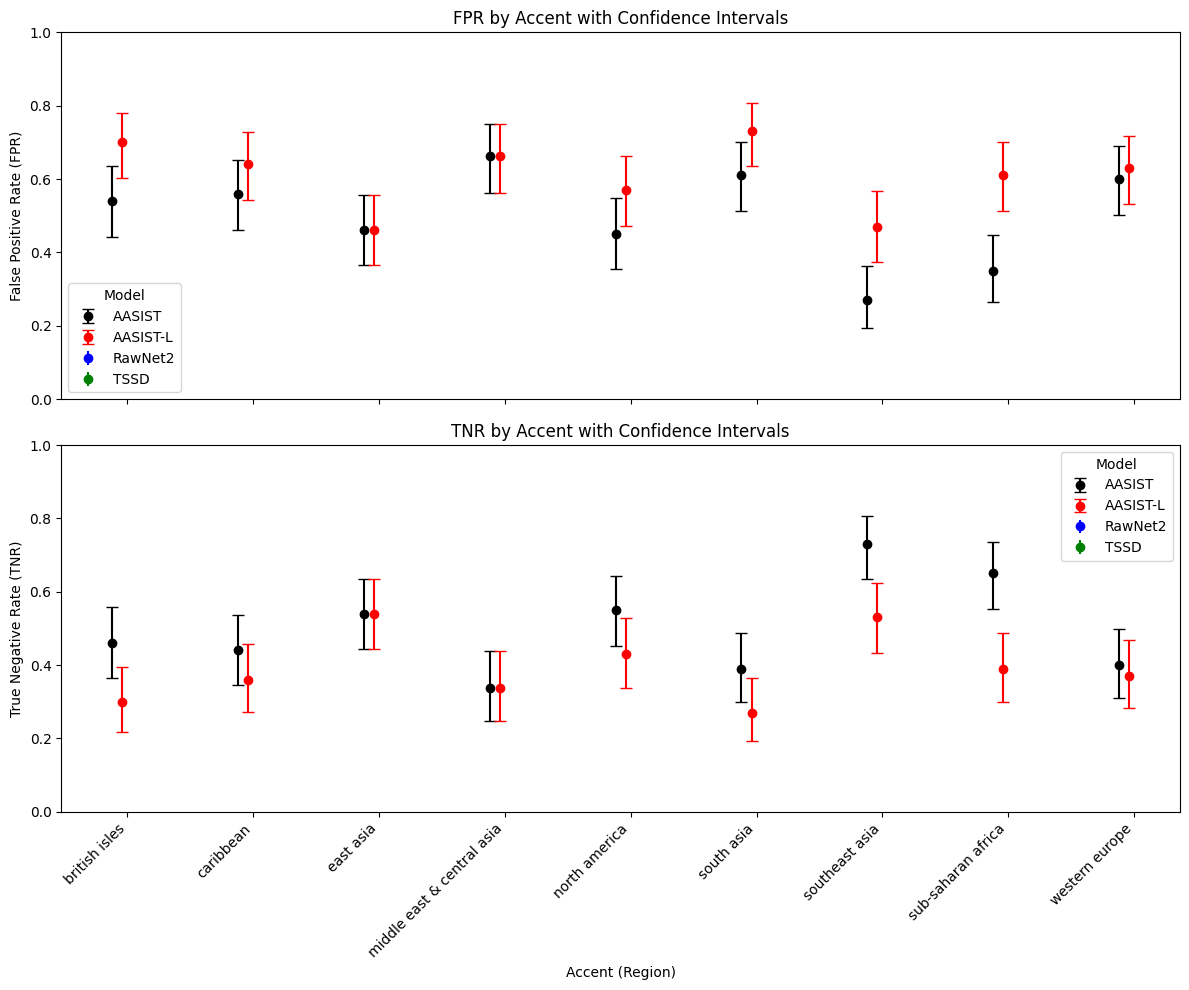

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# === Create a vertically stacked plot for FPR and TNR ===
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

offset = 0.08  # Offset to shift models slightly apart for clarity

# Define model colors and offsets
model_colors = {"AASIST": "black", "AASIST-L": "red", "RawNet2": "blue", "TSSD": "green"}
model_offsets = {"AASIST": -offset*1.5, "AASIST-L": -offset*0.5, "RawNet2": offset*0.5, "TSSD": offset*1.5}

# === Plot FPR with confidence intervals on the first subplot ===
for model in model_colors.keys():
    subset = combined_fpr[combined_fpr["Model"] == model]
    x_positions = np.arange(len(subset["region"])) + model_offsets[model]  # Apply offset
    axes[0].errorbar(x_positions, subset["FPR"], 
                      yerr=[subset["FPR"] - subset["FPR_CI_Lower"], subset["FPR_CI_Upper"] - subset["FPR"]], 
                      fmt="o", color=model_colors[model], capsize=4, label=model)

axes[0].set_ylabel("False Positive Rate (FPR)")
axes[0].set_title("FPR by Accent with Confidence Intervals")
axes[0].legend(title="Model")
axes[0].set_ylim(0, 1)  # Ensure values are between 0 and 1

# === Plot TNR with confidence intervals on the second subplot ===
for model in model_colors.keys():
    subset = combined_tnr[combined_tnr["Model"] == model]
    x_positions = np.arange(len(subset["region"])) + model_offsets[model]  # Apply offset
    axes[1].errorbar(x_positions, subset["TNR"], 
                      yerr=[subset["TNR"] - subset["TNR_CI_Lower"], subset["TNR_CI_Upper"] - subset["TNR"]], 
                      fmt="o", color=model_colors[model], capsize=4, label=model)

axes[1].set_ylabel("True Negative Rate (TNR)")
axes[1].set_title("TNR by Accent with Confidence Intervals")
axes[1].legend(title="Model")
axes[1].set_ylim(0, 1)  # Ensure values are between 0 and 1

# === Set x-axis labels and ticks ===
plt.xticks(ticks=np.arange(len(combined_fpr["region"].unique())), 
           labels=combined_fpr["region"].unique(), rotation=45, ha="right")
plt.xlabel("Accent (Region)")

plt.tight_layout()
plt.show()

In [21]:
combined_fpr.to_csv('combined_fpr.csv')
combined_tnr.to_csv('combined_tnr.csv')

In [22]:
combined_fpr

,region,FPR,FPR_CI_Lower,FPR_CI_Upper,Model
0,british isles,0.59,0.492014,0.681327,AASIST
1,multiple accents,0.48,0.384646,0.576834,AASIST
2,north america,0.69,0.593739,0.772203,AASIST
3,other,0.47,0.375108,0.567111,AASIST
4,south asia,0.47,0.375108,0.567111,AASIST
5,southeast asia,0.83,0.744520,0.891064,AASIST
6,sub-saharan africa,0.74,0.646290,0.815953,AASIST
0,british isles,0.58,0.482065,0.672016,AASIST-L
1,multiple accents,0.43,0.337333,0.527846,AASIST-L
2,north america,0.63,0.532205,0.718176,AASIST-L


### Gender-wise Comparison

In [29]:
import pandas as pd

# === Load the final results CSV for all models ===
df_aasist = pd.read_csv("aasist_env/final_results.csv")
df_aasist_l = pd.read_csv("aasist_env/final_results2.csv")  # AASIST-L model
# df_rawnet2 = pd.read_csv("rawnet2/rawnet_env/final_results_rawnet2.csv") # RawNet2 model
# df_tssd = pd.read_csv("tssdnet/tssd_env/final_results_tssd.csv")  # TSSD model

# === Define the classification threshold ===
THRESHOLD = 0.5

# Function to clean accent names (remove parentheses and anything after)
def clean_accent_name(accent):
    return accent.split("(")[0].strip()

# Apply cleaning function to all datasets
# for df in [df_aasist, df_aasist_l, df_rawnet2, df_tssd]:
for df in [df_aasist, df_aasist_l]:
    df["region"] = df["region"].apply(clean_accent_name)

# === Standardize Predictions: 1 = Spoof, 0 = Bonafide ===
df_aasist["predicted_spoof"] = (df_aasist["prediction_score"] < THRESHOLD).astype(int)
df_aasist_l["predicted_spoof"] = (df_aasist_l["prediction_score"] < THRESHOLD).astype(int)
# df_rawnet2["predicted_spoof"] = (df_rawnet2["prediction_score"] < THRESHOLD).astype(int)
# df_tssd["predicted_spoof"] = (df_tssd["prediction_score"] < THRESHOLD).astype(int) # **Fix for TSSD**

# **Fix: Assume ground truth is all real (1) since FPR assumes no spoofed examples**
# for df in [df_aasist, df_aasist_l, df_rawnet2, df_tssd]:
for df in [df_aasist, df_aasist_l]:
    df["actual_label"] = 1  # All samples assumed to be bonafide

# === Compute FP (False Positives) and TN (True Negatives) ===
# for df in [df_aasist, df_aasist_l, df_rawnet2, df_tssd]:
for df in [df_aasist, df_aasist_l]:
    df["FP"] = (df["predicted_spoof"] == 1) & (df["actual_label"] == 1)  # False spoof detection
    df["TN"] = (df["predicted_spoof"] == 0) & (df["actual_label"] == 1)  # Correctly identified bonafide

# === Standardize Gender Column (Mapping to 'men' and 'women') ===
def map_gender(gender):
    if gender in ["male_masculine"]:
        return "men"
    elif gender in ["female_feminine"]:
        return "women"
    return "unknown"  # Handle potential missing values

# for df in [df_aasist, df_aasist_l, df_rawnet2, df_tssd]:
for df in [df_aasist, df_aasist_l]:    
    df["gender_category"] = df["gender"].apply(map_gender)

# === Function to Compute Region-wise Metrics ===
def compute_metrics(df, model_name, groupby_col="region"):
    metrics = df.groupby(groupby_col).agg(
        total_samples=("actual_label", "count"),
        false_positives=("FP", "sum"),
        true_negatives=("TN", "sum")
    )
    metrics["FPR"] = metrics["false_positives"] / metrics["total_samples"]
    metrics["TNR"] = metrics["true_negatives"] / metrics["total_samples"]
    metrics = metrics.reset_index()
    metrics["Model"] = model_name
    return metrics


# === Compute gender-wise metrics for all models ===
gender_metrics_aasist = compute_metrics(df_aasist, "AASIST", groupby_col="gender_category")
gender_metrics_aasist_l = compute_metrics(df_aasist_l, "AASIST-L", groupby_col="gender_category")
# gender_metrics_rawnet2 = compute_metrics(df_rawnet2, "RawNet2", groupby_col="gender_category")
# gender_metrics_tssd = compute_metrics(df_tssd, "TSSD", groupby_col="gender_category")

# gender_metrics_combined = pd.concat(
#     [gender_metrics_aasist, gender_metrics_aasist_l, gender_metrics_rawnet2, gender_metrics_tssd],
#     ignore_index=True
# )

gender_metrics_combined = pd.concat(
    [gender_metrics_aasist, gender_metrics_aasist_l],
    ignore_index=True
)

# === Print confirmation ===
print("All models' gender-wise metrics successfully computed and combined!")

All models' gender-wise metrics successfully computed and combined!


In [30]:
import numpy as np
import pandas as pd
from scipy import stats

# === Function to calculate confidence intervals for proportions using Wilson Score Interval ===
def compute_confidence_interval(proportion, total, confidence=0.95):
    """Compute the confidence interval for a proportion using the Wilson Score Interval."""
    if total == 0:
        return (0, 0)
    z = stats.norm.ppf((1 + confidence) / 2)  # Z-score for confidence level
    p = proportion
    n = total
    center = (p + (z**2) / (2 * n)) / (1 + (z**2) / n)
    margin = (z * np.sqrt((p * (1 - p) / n) + (z**2) / (4 * n**2))) / (1 + (z**2) / n)
    return center - margin, center + margin

# === Function to apply CI computation for both FPR & TNR ===
def apply_confidence_intervals(df):
    df["FPR_CI_Lower"], df["FPR_CI_Upper"] = zip(*df.apply(
        lambda row: compute_confidence_interval(row["FPR"], row["total_samples"]),
        axis=1
    ))
    df["TNR_CI_Lower"], df["TNR_CI_Upper"] = zip(*df.apply(
        lambda row: compute_confidence_interval(row["TNR"], row["total_samples"]),
        axis=1
    ))
    return df

# === Apply confidence interval calculation to all models ===
# all_gender_metrics = [gender_metrics_aasist, gender_metrics_aasist_l, gender_metrics_rawnet2, gender_metrics_tssd]
all_gender_metrics = [gender_metrics_aasist, gender_metrics_aasist_l]
for i, df in enumerate(all_gender_metrics):
    all_gender_metrics[i] = apply_confidence_intervals(df)

# gender_metrics_aasist, gender_metrics_aasist_l, gender_metrics_rawnet2, gender_metrics_tssd = all_gender_metrics
gender_metrics_aasist, gender_metrics_aasist_l = all_gender_metrics

# === Combine all models into a single DataFrame ===
combined_fpr_gender = pd.concat([
    gender_metrics_aasist[["gender_category", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]],
    gender_metrics_aasist_l[["gender_category", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]]# ,
    # gender_metrics_rawnet2[["gender_category", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]],
    # gender_metrics_tssd[["gender_category", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]]
], ignore_index=True)

combined_tnr_gender = pd.concat([
    gender_metrics_aasist[["gender_category", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]],
    gender_metrics_aasist_l[["gender_category", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]]# ,
    # gender_metrics_rawnet2[["gender_category", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]],
    # gender_metrics_tssd[["gender_category", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]]
], ignore_index=True)

# === Print confirmation ===
print("Confidence intervals applied and all models successfully combined for gender analysis!")

Confidence intervals applied and all models successfully combined for gender analysis!


In [31]:
combined_fpr_gender

,gender_category,FPR,FPR_CI_Lower,FPR_CI_Upper,Model
0,men,0.537143,0.484785,0.588694,AASIST
1,women,0.242857,0.200882,0.290415,AASIST
2,men,0.591429,0.539208,0.641664,AASIST-L
3,women,0.320000,0.273311,0.370598,AASIST-L


In [34]:
combined_tnr_gender

,gender_category,TNR,TNR_CI_Lower,TNR_CI_Upper,Model
0,men,0.462857,0.411306,0.515215,AASIST
1,women,0.757143,0.709585,0.799118,AASIST
2,men,0.408571,0.358336,0.460792,AASIST-L
3,women,0.680000,0.629402,0.726689,AASIST-L


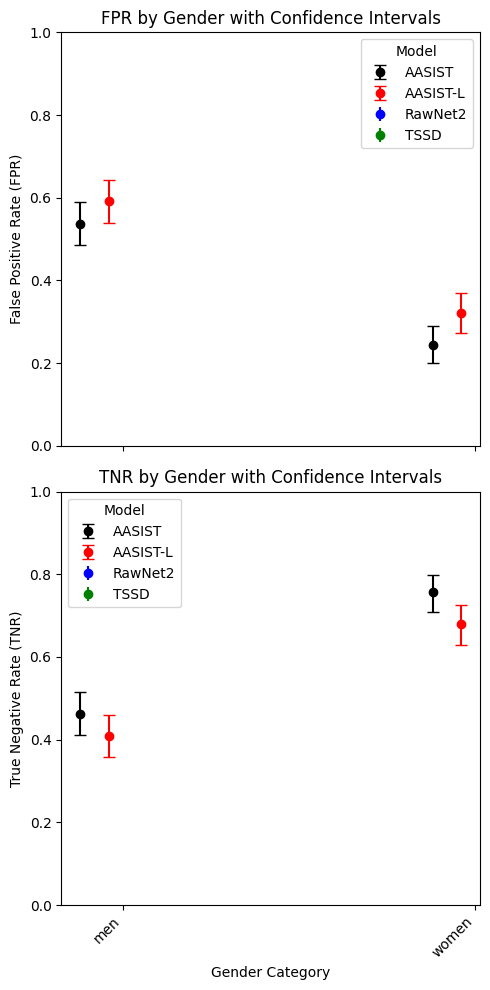

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# === Create a vertically stacked plot for FPR and TNR ===
fig, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)

offset = 0.08  # Offset to shift models slightly apart for clarity

# Define model colors and offsets
model_colors = {"AASIST": "black", "AASIST-L": "red", "RawNet2": "blue", "TSSD": "green"}
model_offsets = {"AASIST": -offset*1.5, "AASIST-L": -offset*0.5, "RawNet2": offset*0.5, "TSSD": offset*1.5}

# === Plot FPR with confidence intervals on the first subplot ===
for model in model_colors.keys():
    subset = combined_fpr_gender[combined_fpr_gender["Model"] == model]
    x_positions = np.arange(len(subset["gender_category"])) + model_offsets[model]  # Apply offset
    axes[0].errorbar(x_positions, subset["FPR"], 
                      yerr=[subset["FPR"] - subset["FPR_CI_Lower"], subset["FPR_CI_Upper"] - subset["FPR"]], 
                      fmt="o", color=model_colors[model], capsize=4, label=model)

axes[0].set_ylabel("False Positive Rate (FPR)")
axes[0].set_title("FPR by Gender with Confidence Intervals")
axes[0].legend(title="Model")
axes[0].set_ylim(0, 1)  # Ensure values are between 0 and 1

# === Plot TNR with confidence intervals on the second subplot ===
for model in model_colors.keys():
    subset = combined_tnr_gender[combined_tnr_gender["Model"] == model]
    x_positions = np.arange(len(subset["gender_category"])) + model_offsets[model]  # Apply offset
    axes[1].errorbar(x_positions, subset["TNR"], 
                      yerr=[subset["TNR"] - subset["TNR_CI_Lower"], subset["TNR_CI_Upper"] - subset["TNR"]], 
                      fmt="o", color=model_colors[model], capsize=4, label=model)

axes[1].set_ylabel("True Negative Rate (TNR)")
axes[1].set_title("TNR by Gender with Confidence Intervals")
axes[1].legend(title="Model")
axes[1].set_ylim(0, 1)  # Ensure values are between 0 and 1

# === Set x-axis labels and ticks ===
plt.xticks(ticks=np.arange(len(combined_fpr_gender["gender_category"].unique())), 
           labels=combined_fpr_gender["gender_category"].unique(), rotation=45, ha="right")
plt.xlabel("Gender Category")

plt.tight_layout()
plt.show()

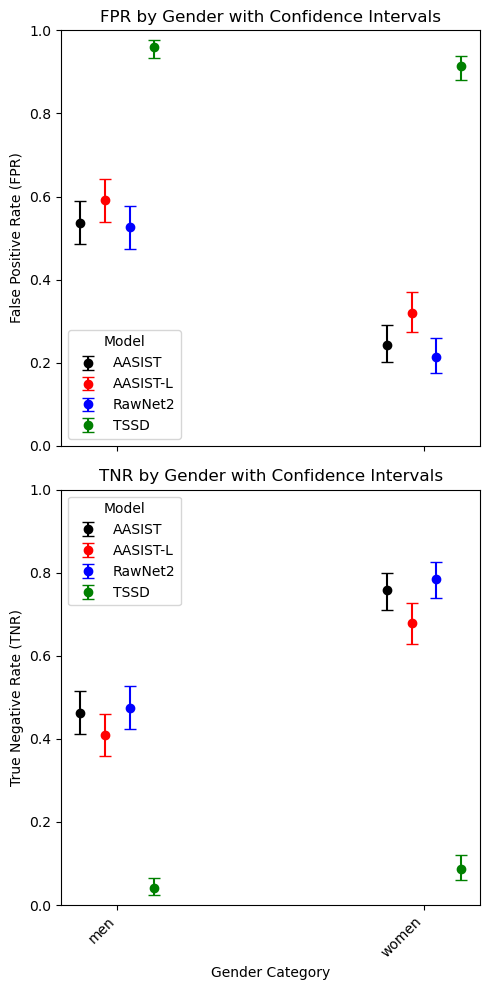

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# === Create a vertically stacked plot for FPR and TNR ===
fig, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)

offset = 0.08  # Offset to shift models slightly apart for clarity

# Define model colors and offsets
model_colors = {"AASIST": "black", "AASIST-L": "red", "RawNet2": "blue", "TSSD": "green"}
model_offsets = {"AASIST": -offset*1.5, "AASIST-L": -offset*0.5, "RawNet2": offset*0.5, "TSSD": offset*1.5}

# === Plot FPR with confidence intervals on the first subplot ===
for model in model_colors.keys():
    subset = combined_fpr_gender[combined_fpr_gender["Model"] == model]
    x_positions = np.arange(len(subset["gender_category"])) + model_offsets[model]  # Apply offset
    axes[0].errorbar(x_positions, subset["FPR"], 
                      yerr=[subset["FPR"] - subset["FPR_CI_Lower"], subset["FPR_CI_Upper"] - subset["FPR"]], 
                      fmt="o", color=model_colors[model], capsize=4, label=model)

axes[0].set_ylabel("False Positive Rate (FPR)")
axes[0].set_title("FPR by Gender with Confidence Intervals")
axes[0].legend(title="Model")
axes[0].set_ylim(0, 1)  # Ensure values are between 0 and 1

# === Plot TNR with confidence intervals on the second subplot ===
for model in model_colors.keys():
    subset = combined_tnr_gender[combined_tnr_gender["Model"] == model]
    x_positions = np.arange(len(subset["gender_category"])) + model_offsets[model]  # Apply offset
    axes[1].errorbar(x_positions, subset["TNR"], 
                      yerr=[subset["TNR"] - subset["TNR_CI_Lower"], subset["TNR_CI_Upper"] - subset["TNR"]], 
                      fmt="o", color=model_colors[model], capsize=4, label=model)

axes[1].set_ylabel("True Negative Rate (TNR)")
axes[1].set_title("TNR by Gender with Confidence Intervals")
axes[1].legend(title="Model")
axes[1].set_ylim(0, 1)  # Ensure values are between 0 and 1

# === Set x-axis labels and ticks ===
plt.xticks(ticks=np.arange(len(combined_fpr_gender["gender_category"].unique())), 
           labels=combined_fpr_gender["gender_category"].unique(), rotation=45, ha="right")
plt.xlabel("Gender Category")

plt.tight_layout()
plt.show()

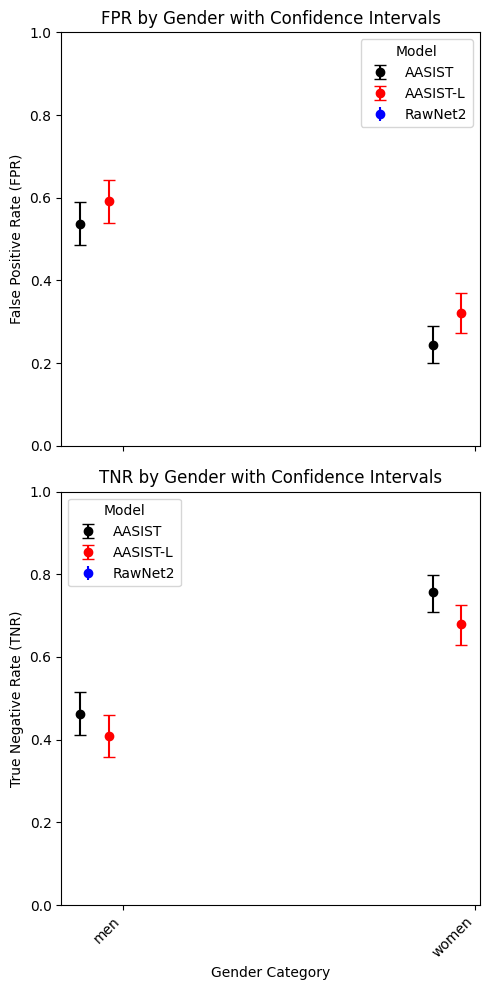

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# === Create a vertically stacked plot for FPR and TNR ===
fig, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)

offset = 0.08  # Offset to shift models slightly apart for clarity

# Define model colors and offsets
model_colors = {"AASIST": "black", "AASIST-L": "red", "RawNet2": "blue"}
model_offsets = {"AASIST": -offset*1.5, "AASIST-L": -offset*0.5, "RawNet2": offset*0.5}

# === Plot FPR with confidence intervals on the first subplot ===
for model in model_colors.keys():
    subset = combined_fpr_gender[combined_fpr_gender["Model"] == model]
    x_positions = np.arange(len(subset["gender_category"])) + model_offsets[model]  # Apply offset
    axes[0].errorbar(x_positions, subset["FPR"], 
                      yerr=[subset["FPR"] - subset["FPR_CI_Lower"], subset["FPR_CI_Upper"] - subset["FPR"]], 
                      fmt="o", color=model_colors[model], capsize=4, label=model)

axes[0].set_ylabel("False Positive Rate (FPR)")
axes[0].set_title("FPR by Gender with Confidence Intervals")
axes[0].legend(title="Model")
axes[0].set_ylim(0, 1)  # Ensure values are between 0 and 1

# === Plot TNR with confidence intervals on the second subplot ===
for model in model_colors.keys():
    subset = combined_tnr_gender[combined_tnr_gender["Model"] == model]
    x_positions = np.arange(len(subset["gender_category"])) + model_offsets[model]  # Apply offset
    axes[1].errorbar(x_positions, subset["TNR"], 
                      yerr=[subset["TNR"] - subset["TNR_CI_Lower"], subset["TNR_CI_Upper"] - subset["TNR"]], 
                      fmt="o", color=model_colors[model], capsize=4, label=model)

axes[1].set_ylabel("True Negative Rate (TNR)")
axes[1].set_title("TNR by Gender with Confidence Intervals")
axes[1].legend(title="Model")
axes[1].set_ylim(0, 1)  # Ensure values are between 0 and 1

# === Set x-axis labels and ticks ===
plt.xticks(ticks=np.arange(len(combined_fpr_gender["gender_category"].unique())), 
           labels=combined_fpr_gender["gender_category"].unique(), rotation=45, ha="right")
plt.xlabel("Gender Category")

plt.tight_layout()
plt.show()

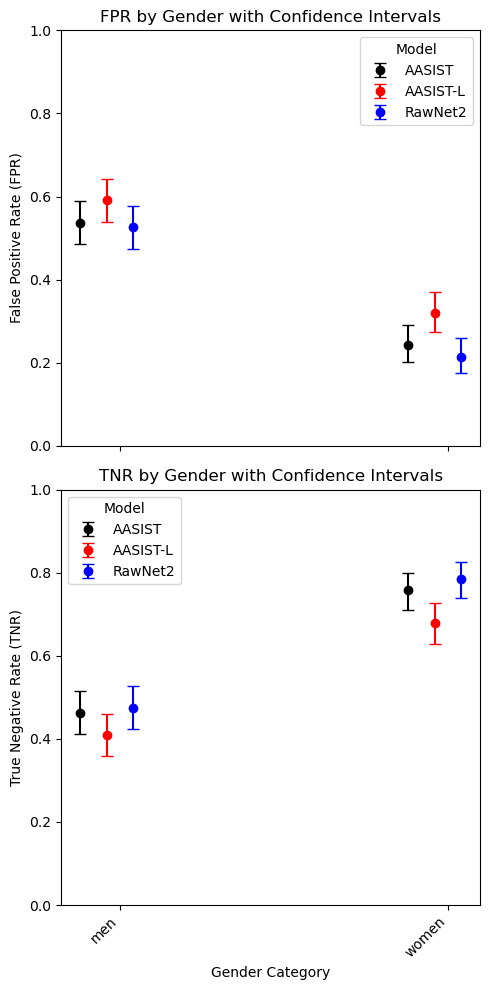

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# === Create a vertically stacked plot for FPR and TNR ===
fig, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)

offset = 0.08  # Offset to shift models slightly apart for clarity

# Define model colors and offsets
model_colors = {"AASIST": "black", "AASIST-L": "red", "RawNet2": "blue"}
model_offsets = {"AASIST": -offset*1.5, "AASIST-L": -offset*0.5, "RawNet2": offset*0.5}

# === Plot FPR with confidence intervals on the first subplot ===
for model in model_colors.keys():
    subset = combined_fpr_gender[combined_fpr_gender["Model"] == model]
    x_positions = np.arange(len(subset["gender_category"])) + model_offsets[model]  # Apply offset
    axes[0].errorbar(x_positions, subset["FPR"], 
                      yerr=[subset["FPR"] - subset["FPR_CI_Lower"], subset["FPR_CI_Upper"] - subset["FPR"]], 
                      fmt="o", color=model_colors[model], capsize=4, label=model)

axes[0].set_ylabel("False Positive Rate (FPR)")
axes[0].set_title("FPR by Gender with Confidence Intervals")
axes[0].legend(title="Model")
axes[0].set_ylim(0, 1)  # Ensure values are between 0 and 1

# === Plot TNR with confidence intervals on the second subplot ===
for model in model_colors.keys():
    subset = combined_tnr_gender[combined_tnr_gender["Model"] == model]
    x_positions = np.arange(len(subset["gender_category"])) + model_offsets[model]  # Apply offset
    axes[1].errorbar(x_positions, subset["TNR"], 
                      yerr=[subset["TNR"] - subset["TNR_CI_Lower"], subset["TNR_CI_Upper"] - subset["TNR"]], 
                      fmt="o", color=model_colors[model], capsize=4, label=model)

axes[1].set_ylabel("True Negative Rate (TNR)")
axes[1].set_title("TNR by Gender with Confidence Intervals")
axes[1].legend(title="Model")
axes[1].set_ylim(0, 1)  # Ensure values are between 0 and 1

# === Set x-axis labels and ticks ===
plt.xticks(ticks=np.arange(len(combined_fpr_gender["gender_category"].unique())), 
           labels=combined_fpr_gender["gender_category"].unique(), rotation=45, ha="right")
plt.xlabel("Gender Category")

plt.tight_layout()
plt.show()

In [123]:
cfpr

,region,FPR,FPR_CI_Lower,FPR_CI_Upper,Model
0,british isles,41.0,31.867313,50.798570,AASIST
1,multiple accents,52.0,42.316578,61.535448,AASIST
2,north america,31.0,22.779697,40.626056,AASIST
3,other,53.0,43.288857,62.489182,AASIST
4,south asia,53.0,43.288857,62.489182,AASIST
5,southeast asia,17.0,10.893566,25.548005,AASIST
6,sub-saharan africa,26.0,18.404698,35.370989,AASIST
7,british isles,42.0,32.798383,51.793513,AASIST-L
8,multiple accents,57.0,47.215390,66.266701,AASIST-L
9,north america,37.0,28.182361,46.779470,AASIST-L


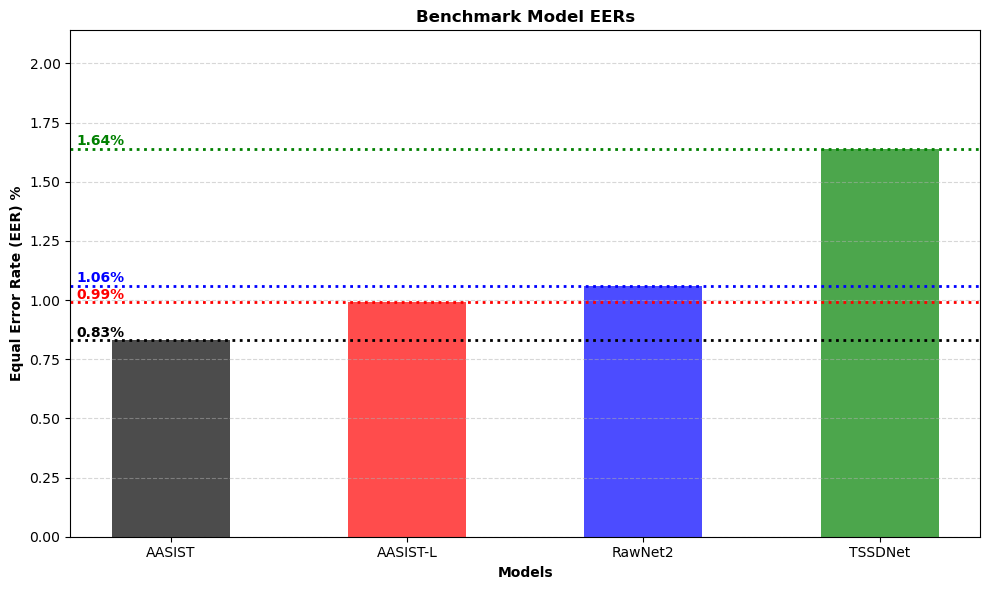

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# Model names and their respective EERs
models = ["AASIST", "AASIST-L", "RawNet2", "TSSDNet"]
eer_values = [0.83, 0.99, 1.06, 1.64]  # EER in %

# Define model colors matching previous convention
model_colors = {"AASIST": "black", "AASIST-L": "red", "RawNet2": "blue", "TSSDNet": "green"}

# Create figure with white background
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
ax.set_facecolor("white")  # Ensure white background

# Plot the bar graph
bars = ax.bar(models, eer_values, color=[model_colors[m] for m in models], alpha=0.7, width= 0.5, label="Benchmark EERs")

# Plot the dotted horizontal benchmark EERs with their labels positioned to the left
for eer, model in zip(eer_values, models):
    ax.axhline(y=eer, color=model_colors[model], linestyle="dotted", linewidth=2, label=f"{model} EER")
    ax.text(-0.4, eer + 0.015, f"{eer:.2f}%", color=model_colors[model], fontsize=10, fontweight="bold", ha="left")  # Move text to the left

# Labels and title
ax.set_xlabel("Models", fontweight="bold")
ax.set_ylabel("Equal Error Rate (EER) %", fontweight="bold")
ax.set_title("Benchmark Model EERs", fontweight="bold")
ax.set_ylim(0, max(eer_values) + 0.5)  # Adjust y-axis for clarity

ax.grid(axis='y', linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

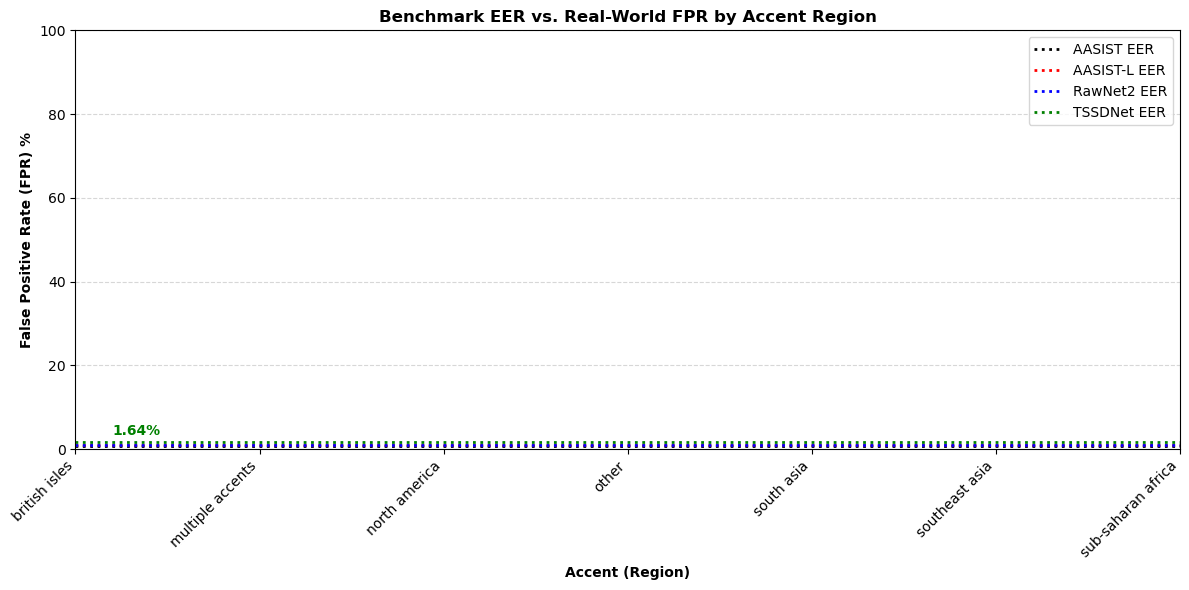

In [147]:
import numpy as np
import matplotlib.pyplot as plt


# Model names and their respective EERs
models = ["AASIST", "AASIST-L", "RawNet2", "TSSDNet"]
eer_values = [0.83, 0.99, 1.06, 1.64]  # EER in %


# Define model colors matching previous convention
model_colors = {"AASIST": "black", "AASIST-L": "red", "RawNet2": "blue", "TSSDNet": "green"}

# Create figure with white background
fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")

# Plot the dotted horizontal benchmark EERs with labels on the left side
for model, eer in zip(models, eer_values):
    ax.axhline(y=eer, color=model_colors[model], linestyle="dotted", linewidth=2, label=f"{model} EER")
    if model == 'TSSDNet':
        ax.text(0.2, eer + 1, f"{eer:.2f}%", color=model_colors[model], fontsize=10, fontweight="bold", ha="left", va="bottom")

# Labels and title
# Set x-axis labels and ticks
plt.xticks(ticks=np.arange(len(cfpr["region"].unique())), 
           labels=cfpr["region"].unique(), rotation=45, ha="right")
ax.set_xlabel("Accent (Region)", fontweight="bold")
ax.set_ylabel("False Positive Rate (FPR) %", fontweight="bold")
ax.set_title("Benchmark EER vs. Real-World FPR by Accent Region", fontweight="bold")
ax.set_ylim(0, 100)  # Set scale from 0 to 100%
ax.legend(loc="upper right")
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

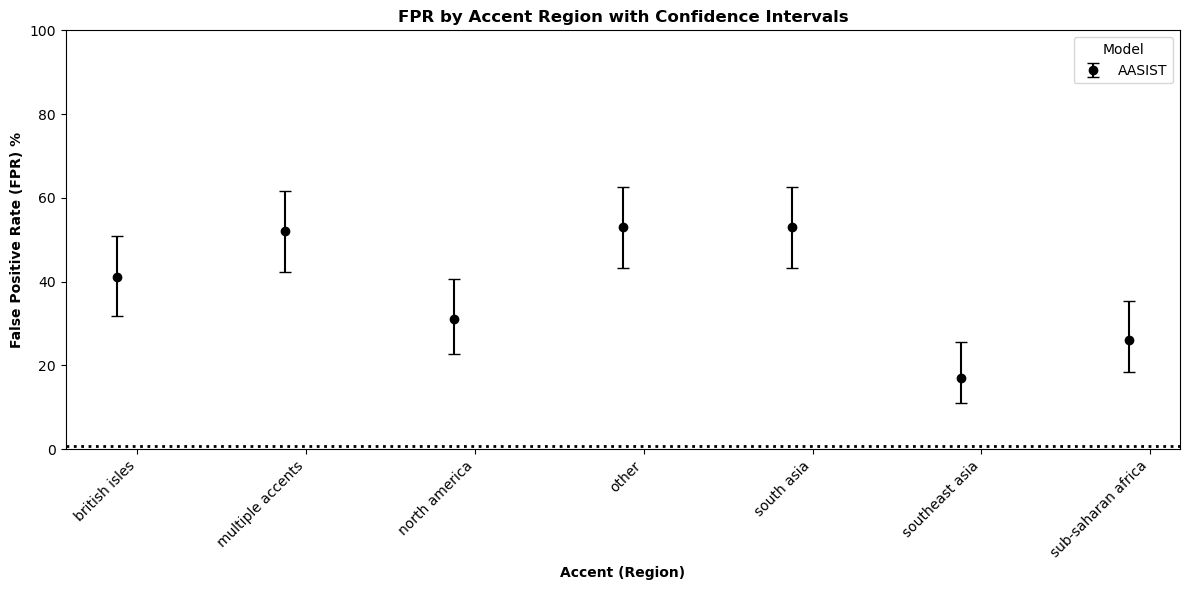

In [156]:
import numpy as np
import matplotlib.pyplot as plt

cfpr = combined_fpr.copy()
# Define model colors and offsets
model_colors = {"AASIST": "black"}
offset = 0.08  # Offset to shift models slightly apart for clarity
model_offsets = {"AASIST": -offset*1.55}

# Model names and their respective EERs (convert to percentage)
models = ["AASIST"]
eer_values = np.array([0.83, 0.99, 1.06, 1.64])  # EER in %

# Convert combined_fpr values to percentages
cfpr["FPR"] *= 100
cfpr["FPR_CI_Lower"] *= 100
cfpr["FPR_CI_Upper"] *= 100

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")

# Plot FPR with confidence intervals for each model
for model in model_colors.keys():
    if model not in cfpr["Model"].unique():
        continue  # Skip missing models

    subset = cfpr[cfpr["Model"] == model]
    x_positions = np.arange(len(subset["region"])) + model_offsets[model]  # Apply offset
    ax.errorbar(x_positions, subset["FPR"], 
                yerr=[subset["FPR"] - subset["FPR_CI_Lower"], subset["FPR_CI_Upper"] - subset["FPR"]], 
                fmt="o", color=model_colors[model], capsize=4, label=model)

# Plot the dotted horizontal benchmark EERs with labels on the left side
for model, eer in zip(models, eer_values):
    if model == 'TSSDNet':
        ax.axhline(y=eer, color=model_colors[model], linestyle="dotted", linewidth=2, label="TSSDNet EER")
        ax.text(-0.5, eer + 1, f"{eer:.2f}%", color=model_colors[model], fontsize=10, fontweight="bold", ha="left", va="bottom")
    else:
        ax.axhline(y=eer, color=model_colors[model], linestyle="dotted", linewidth=2, label="_nolegend_")

# Labels and title
ax.set_ylabel("False Positive Rate (FPR) %", fontweight="bold")
ax.set_xlabel("Accent (Region)", fontweight="bold")
ax.set_title("FPR by Accent Region with Confidence Intervals", fontweight="bold")
ax.legend(title="Model")
ax.set_ylim(0, 100)  # Ensure values fit well

# Set x-axis labels and ticks
plt.xticks(ticks=np.arange(len(cfpr["region"].unique())), 
           labels=cfpr["region"].unique(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

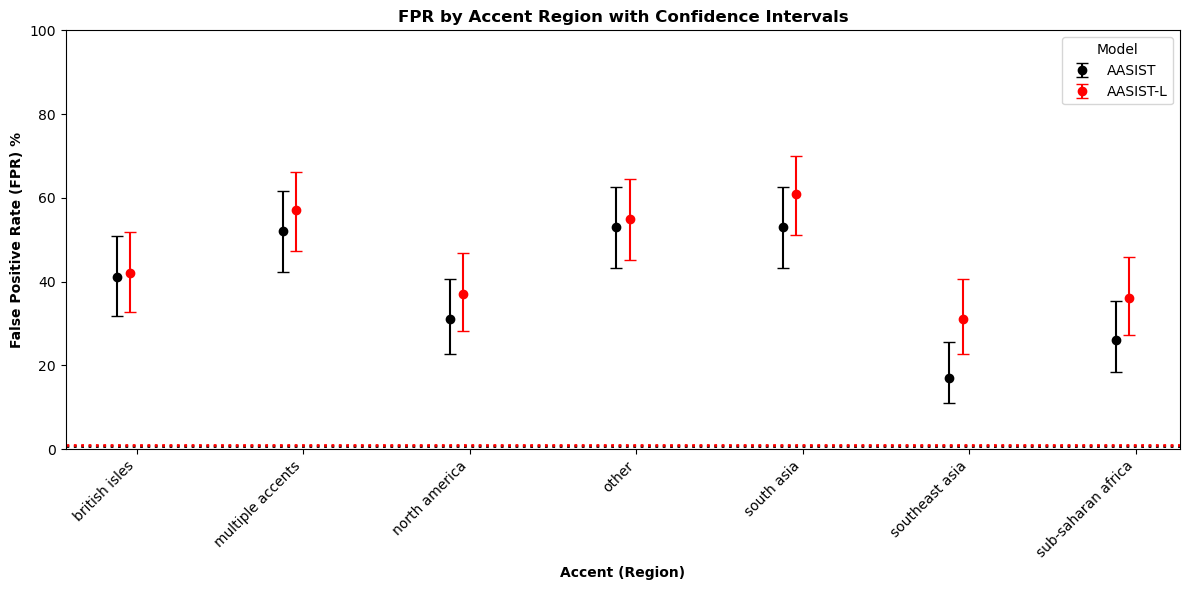

In [155]:
import numpy as np
import matplotlib.pyplot as plt

cfpr = combined_fpr.copy()
# Define model colors and offsets
model_colors = {"AASIST": "black", "AASIST-L": "red"}
offset = 0.08  # Offset to shift models slightly apart for clarity
model_offsets = {"AASIST": -offset*1.5, "AASIST-L": -offset*0.5}

# Model names and their respective EERs (convert to percentage)
models = ["AASIST", "AASIST-L"]
eer_values = np.array([0.83, 0.99, 1.06, 1.64])  # EER in %

# Convert combined_fpr values to percentages
cfpr["FPR"] *= 100
cfpr["FPR_CI_Lower"] *= 100
cfpr["FPR_CI_Upper"] *= 100

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")

# Plot FPR with confidence intervals for each model
for model in model_colors.keys():
    if model not in cfpr["Model"].unique():
        continue  # Skip missing models

    subset = cfpr[cfpr["Model"] == model]
    x_positions = np.arange(len(subset["region"])) + model_offsets[model]  # Apply offset
    ax.errorbar(x_positions, subset["FPR"], 
                yerr=[subset["FPR"] - subset["FPR_CI_Lower"], subset["FPR_CI_Upper"] - subset["FPR"]], 
                fmt="o", color=model_colors[model], capsize=4, label=model)

# Plot the dotted horizontal benchmark EERs with labels on the left side
for model, eer in zip(models, eer_values):
    if model == 'TSSDNet':
        ax.axhline(y=eer, color=model_colors[model], linestyle="dotted", linewidth=2, label="TSSDNet EER")
        ax.text(-0.5, eer + 1, f"{eer:.2f}%", color=model_colors[model], fontsize=10, fontweight="bold", ha="left", va="bottom")
    else:
        ax.axhline(y=eer, color=model_colors[model], linestyle="dotted", linewidth=2, label="_nolegend_")

# Labels and title
ax.set_ylabel("False Positive Rate (FPR) %", fontweight="bold")
ax.set_xlabel("Accent (Region)", fontweight="bold")
ax.set_title("FPR by Accent Region with Confidence Intervals", fontweight="bold")
ax.legend(title="Model")
ax.set_ylim(0, 100)  # Ensure values fit well

# Set x-axis labels and ticks
plt.xticks(ticks=np.arange(len(cfpr["region"].unique())), 
           labels=cfpr["region"].unique(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

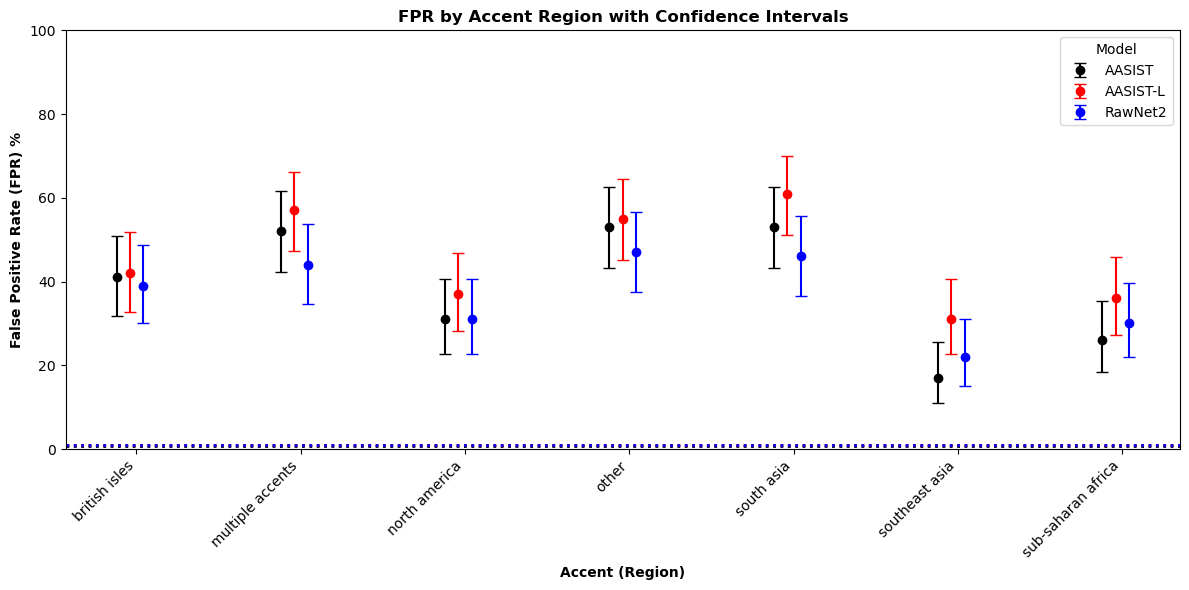

In [154]:
import numpy as np
import matplotlib.pyplot as plt

cfpr = combined_fpr.copy()
# Define model colors and offsets
model_colors = {"AASIST": "black", "AASIST-L": "red", "RawNet2": "blue"}
offset = 0.08  # Offset to shift models slightly apart for clarity
model_offsets = {"AASIST": -offset*1.5, "AASIST-L": -offset*0.5, "RawNet2": offset*0.55}

# Model names and their respective EERs (convert to percentage)
models = ["AASIST", "AASIST-L", "RawNet2"]
eer_values = np.array([0.83, 0.99, 1.06, 1.64])  # EER in %

# Convert combined_fpr values to percentages
cfpr["FPR"] *= 100
cfpr["FPR_CI_Lower"] *= 100
cfpr["FPR_CI_Upper"] *= 100

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")

# Plot FPR with confidence intervals for each model
for model in model_colors.keys():
    if model not in cfpr["Model"].unique():
        continue  # Skip missing models

    subset = cfpr[cfpr["Model"] == model]
    x_positions = np.arange(len(subset["region"])) + model_offsets[model]  # Apply offset
    ax.errorbar(x_positions, subset["FPR"], 
                yerr=[subset["FPR"] - subset["FPR_CI_Lower"], subset["FPR_CI_Upper"] - subset["FPR"]], 
                fmt="o", color=model_colors[model], capsize=4, label=model)

# Plot the dotted horizontal benchmark EERs with labels on the left side
for model, eer in zip(models, eer_values):
    if model == 'TSSDNet':
        ax.axhline(y=eer, color=model_colors[model], linestyle="dotted", linewidth=2, label="TSSDNet EER")
        ax.text(-0.5, eer + 1, f"{eer:.2f}%", color=model_colors[model], fontsize=10, fontweight="bold", ha="left", va="bottom")
    else:
        ax.axhline(y=eer, color=model_colors[model], linestyle="dotted", linewidth=2, label="_nolegend_")

# Labels and title
ax.set_ylabel("False Positive Rate (FPR) %", fontweight="bold")
ax.set_xlabel("Accent (Region)", fontweight="bold")
ax.set_title("FPR by Accent Region with Confidence Intervals", fontweight="bold")
ax.legend(title="Model")
ax.set_ylim(0, 100)  # Ensure values fit well

# Set x-axis labels and ticks
plt.xticks(ticks=np.arange(len(cfpr["region"].unique())), 
           labels=cfpr["region"].unique(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

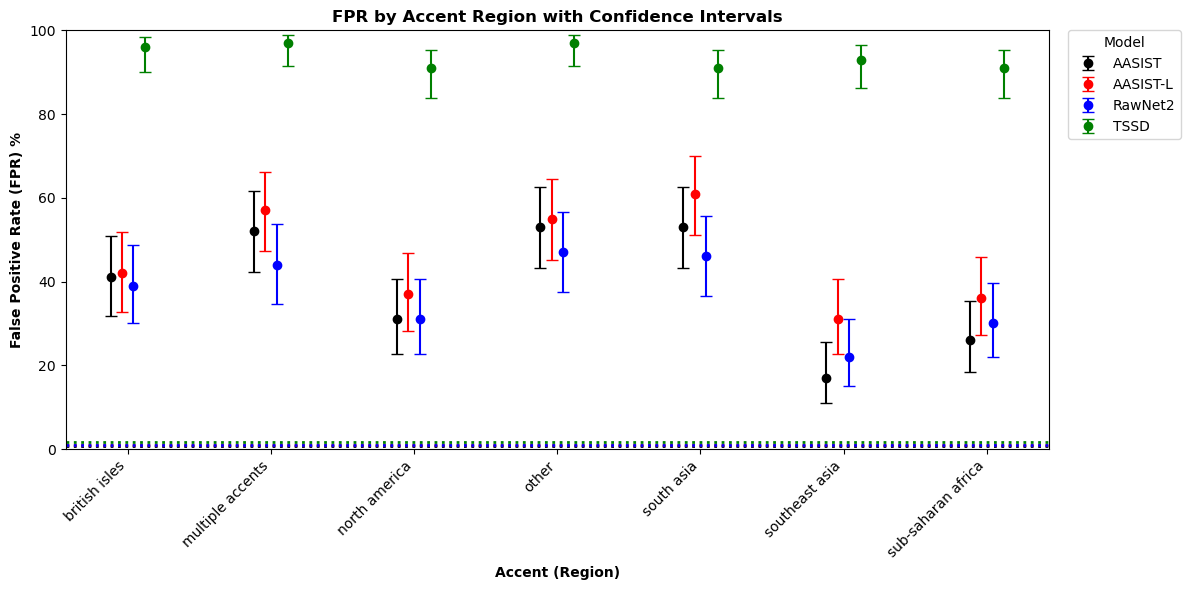

In [159]:
import numpy as np
import matplotlib.pyplot as plt

cfpr = combined_fpr.copy()
# Define model colors and offsets
model_colors = {"AASIST": "black", "AASIST-L": "red", "RawNet2": "blue", "TSSD": "green"}
offset = 0.08  # Offset to shift models slightly apart for clarity
model_offsets = {"AASIST": -offset*1.5, "AASIST-L": -offset*0.5, "RawNet2": offset*0.5, "TSSD": offset*1.5}

# Model names and their respective EERs (convert to percentage)
models = ["AASIST", "AASIST-L", "RawNet2", "TSSD"]
eer_values = np.array([0.83, 0.99, 1.06, 1.64])  # EER in %

# Convert combined_fpr values to percentages
cfpr["FPR"] *= 100
cfpr["FPR_CI_Lower"] *= 100
cfpr["FPR_CI_Upper"] *= 100

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")

# Plot FPR with confidence intervals for each model
for model in model_colors.keys():
    if model not in cfpr["Model"].unique():
        continue  # Skip missing models

    subset = cfpr[cfpr["Model"] == model]
    x_positions = np.arange(len(subset["region"])) + model_offsets[model]  # Apply offset
    ax.errorbar(x_positions, subset["FPR"], 
                yerr=[subset["FPR"] - subset["FPR_CI_Lower"], subset["FPR_CI_Upper"] - subset["FPR"]], 
                fmt="o", color=model_colors[model], capsize=4, label=model)

# Plot the dotted horizontal benchmark EERs with labels on the left side
for model, eer in zip(models, eer_values):
    if model == 'TSSDNet':
        ax.axhline(y=eer, color=model_colors[model], linestyle="dotted", linewidth=2, label="TSSDNet EER")
        ax.text(-0.5, eer + 1, f"{eer:.2f}%", color=model_colors[model], fontsize=10, fontweight="bold", ha="left", va="bottom")
    else:
        ax.axhline(y=eer, color=model_colors[model], linestyle="dotted", linewidth=2, label="_nolegend_")

# Labels and title
ax.set_ylabel("False Positive Rate (FPR) %", fontweight="bold")
ax.set_xlabel("Accent (Region)", fontweight="bold")
ax.set_title("FPR by Accent Region with Confidence Intervals", fontweight="bold")
ax.legend(title="Model", loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
ax.set_ylim(0, 100)  # Ensure values fit well

# Set x-axis labels and ticks
plt.xticks(ticks=np.arange(len(cfpr["region"].unique())), 
           labels=cfpr["region"].unique(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [158]:
cfpr[cfpr['region']=='southeast asia']

,region,FPR,FPR_CI_Lower,FPR_CI_Upper,Model
5,southeast asia,17.0,10.893566,25.548005,AASIST
12,southeast asia,31.0,22.779697,40.626056,AASIST-L
19,southeast asia,22.0,15.001282,31.070354,RawNet2
26,southeast asia,93.0,86.250485,96.568074,TSSD
